In [1]:
#Data Manipulation
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from tqdm import tqdm
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
parameters = {
    "dataset":{
        "path": "../data/data_casal_montserratina/LaMonserratina_CLEAN.csv",
        "trainingSize": .80,
        "testSize": .20
    },
    "validation": {
        "n_splits" : 6
    }
}

In [2]:
def addNLags(df, lags_list):
    lag_df= df.copy()
    for lag in lags_list:
        lag_df[f'lag_{lag}'] = lag_df["Demanda_kWh"].shift(lag * 96).fillna(0)

    return lag_df.fillna(0)
def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.reset_index(inplace=True)
dates = df["Date"]
dates = pd.to_datetime(dates)

df["Demanda_kWh"] = np.log1p(df["Demanda_kWh"].values)
df = addNLags(df, [1,2])
df = df.drop(columns=["Date"], axis=1)
df.columns = df.columns.map(str)

y = df["Demanda_kWh"]
X = df.drop(columns=["Demanda_kWh", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
    "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)
trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
col_names = list(X.columns)

X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
X_test, y_test = X.loc[trainingSize:, :].copy(), y.loc[trainingSize:].copy()

X_train_dates = dates.loc[:trainingSize].copy()
X_test_dates = dates.loc[trainingSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Test Size: {len(X_test)}")
X.columns

Total Lags: 12046
Training Size:9637
Test Size: 2410


Index(['temperature_2m_C', 'shortwave_radiation_W/m2',
       'diffuse_radiation_W/m2', 'direct_normal_irradiance_W/m2', 'Hour',
       'isWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'Month_cos',
       'isHoliday', 'lag_1', 'lag_2'],
      dtype='object')

In [4]:
import plotly.graph_objects as go
def plotDatasetSplit(X_train_dates, X_test_dates, y_train, y_test):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_train_dates, y=y_train, mode="lines", name="Train"))
    fig.add_trace(go.Scatter(x=X_test_dates, y=y_test, mode="lines", name="Test"))
    fig.update_layout(
        title = "Dataset Partition",
        xaxis_title = "Date",
        yaxis_title ="Demand (kWh)",
        width = 1000,
        height = 400,
        margin = dict(l=30, r=20, t=35, b=60),
        legend = dict(
            orientation = "h",
            yanchor = "bottom",
            y = 1.05,
            xanchor = "right",
            x=1
        )
    )
    fig.write_image("../results/dataset_split.png", width=1000, scale=2, format="png")
    fig.show()

In [5]:
regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=1300, learning_rate = 0.01, max_depth=9, colsample_bytree = .7, colsample_bynode = 0.7, gamma=7, random_state=123)
regressorXGBR.fit(
    X = X_train,
    y = y_train,
    verbose=0
)

y_pred = regressorXGBR.predict(X_test)
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
rmse = root_mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
mape = mean_absolute_percentage_error(np.expm1(y_test), np.expm1(y_pred))
mdape = median_absolute_percentage_error(np.expm1(y_test), np.expm1(y_pred))
print(f"MAE: {mae}, RMSE: {rmse}, MdAPE: {mdape}")

imp_df = pd.DataFrame(data=regressorXGBR.feature_importances_, index=regressorXGBR.feature_names_in_, columns=['importance'])
imp_df.sort_values(by=["importance"])

MAE: 1.3994255757768501, RMSE: 3.2927485339976403, MdAPE: 11.202081890343841


,importance
temperature_2m_C,0.028237
isWeekend,0.044585
lag_2,0.044681
Month_cos,0.044973
isHoliday,0.052374
DayOfWeek_sin,0.054098
diffuse_radiation_W/m2,0.055391
Hour_sin,0.059246
shortwave_radiation_W/m2,0.060147
direct_normal_irradiance_W/m2,0.062080


In [6]:
df = pd.read_csv("../data/data_casal_montserratina/LaMonserratina_CLEAN.csv", index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df["Demanda_kWh"] = np.log1p(df["Demanda_kWh"].values)
def split_train_test(data):
    train_list = []
    test_list = []

    # Agrupar por mes y año
    grouped = data.groupby([data.index.year, data.index.month])

    for _, group in grouped:
        # Ordenar por fecha dentro del grupo
        group = group.sort_index()
        # Tomar las tres primeras semanas como training
        train_list.append(group.iloc[:-8*24])
        # Tomar la última semana como test
        test_list.append(group.iloc[-8*24:])

    train = pd.concat(train_list)
    test = pd.concat(test_list)

    return train, test

# Divide el DataFrame
train, test = split_train_test(df)
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(train)}")
print(f"Test Size: {len(test)}")

Total Lags: 12046
Training Size:8782
Test Size: 3264


In [7]:
fig = go.Figure()
train2 = train.copy(deep=True)
test2 = test.copy(deep=True)
min_date = train2.index.min()
max_date = train2.index.max()


fig.add_trace(go.Scatter(x=train2.index, y=train2.Demanda_kWh, mode="lines", name="Train"))
fig.add_trace(go.Scatter(x=test2.index, y=test2.Demanda_kWh, mode="lines", name="Test"))
fig.update_layout(
    title = "Dataset Partition",
    xaxis_title = "Date",
    yaxis_title ="Demand (kWh)",
    width = 1000,
    height = 400,
    margin = dict(l=30, r=20, t=35, b=60),
    legend = dict(
        orientation = "h",
        yanchor = "bottom",
        y = 1.05,
        xanchor = "right",
        x=1
    )
)
fig.show()

In [8]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

train = train.drop(columns=["Date"], axis=1)
test_dates = test["Date"]
test = test.drop(columns=["Date"], axis=1)

df = addNLags(df, [1, 2])

train_y = train["Demanda_kWh"]
test_y = test["Demanda_kWh"]
train_x = train.drop(columns=["Demanda_kWh"], axis=1)
test_x = test.drop(columns=["Demanda_kWh"], axis=1)

regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=1400, learning_rate = 0.003, max_depth=7, colsample_bytree = 0.9, colsample_bynode = 0.9, gamma=7, random_state=123)
regressorXGBR.fit(
    X = train_x,
    y = train_y
)
y_pred = regressorXGBR.predict(test_x)
print(f"XGBR MAE: {mean_absolute_error(test_y, y_pred)}, RMSE: {root_mean_squared_error(test_y, y_pred)}")

XGBR MAE: 0.29473665605061494, RMSE: 0.5084893860455973


In [9]:
test_dates

0      2022-07-24 00:00:00
1      2022-07-24 01:00:00
2      2022-07-24 02:00:00
3      2022-07-24 03:00:00
4      2022-07-24 04:00:00
               ...        
3259   2023-11-29 20:00:00
3260   2023-11-29 21:00:00
3261   2023-11-29 22:00:00
3262   2023-11-29 23:00:00
3263   2023-11-30 00:00:00
Name: Date, Length: 3264, dtype: datetime64[ns]

In [10]:
def plotPredictions(dates, y_pred, y_test):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    fig.show()
    
plotPredictions(test_x.index, y_pred, test_y)

In [11]:
plotPredictions(test_x.index[:24*14], y_pred[:24*14], test_y[:24*14])

In [12]:
plotPredictions(test_x.index[:24*7], y_pred[:24*7], test_y[:24*7])

In [13]:
#Data Manipulation
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import plotly.graph_objects as go
import statsmodels as sm
parameters = {
    "dataset":{
        "path": "../data/data_casal_montserratina/LaMonserratina_CLEAN.csv",
        "trainingSize": .80,
        "testSize": .20
    },
    "validation": {
        "n_splits" : 6
    }
}
def plotPredictions(dates, y_pred, y_test):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    fig.show()

In [14]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None, parse_dates=True, dayfirst=True)
df["Date"] = pd.to_datetime(df["Date"])
df = df[["Demanda_kWh", "Date"]]
df.set_index("Date", inplace=True)
df = df.asfreq('H').fillna(0)
df["Consumo_log"] = df["Demanda_kWh"].apply(np.log1p)
df["Consumo_log_diff"] = df["Consumo_log"].diff()
split_index = int(0.8 * len(df))
train, test = df.iloc[:split_index], df.iloc[split_index:]

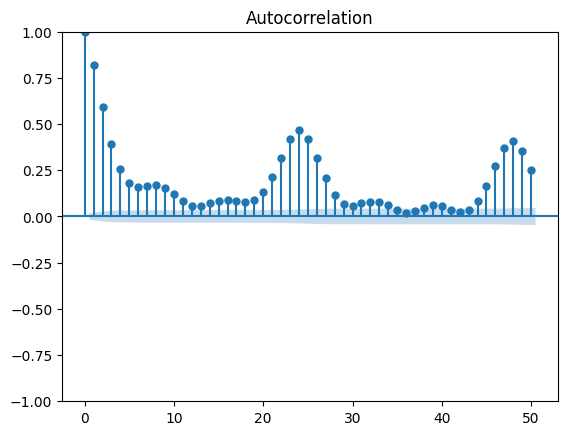

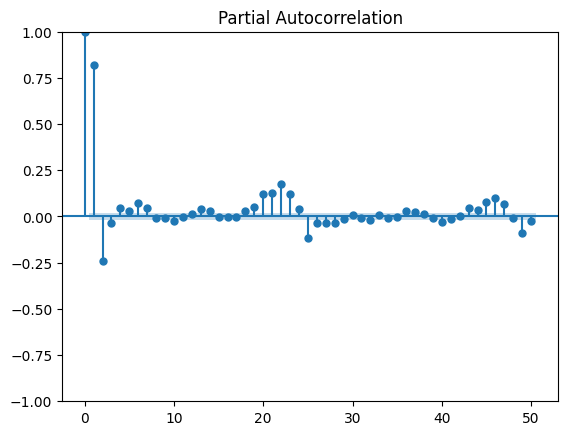

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_original = plot_acf(df["Demanda_kWh"], lags=50)
pacf_original = plot_pacf(df["Demanda_kWh"], lags=50)

In [16]:
best_arima_model = sm.tsa.statespace.SARIMAX(
    endog = df["Demanda_kWh_log"],
    order = (2,0,2), # p => Lags d => Diff q => Moving  
    seasonal_order = (2,0,2,24),
    enforce_stationarity = False,
    enforce_invertibility = False
)
best_arima_model.initialize_approximate_diffuse() 
best_arima_model_fitted = best_arima_model.fit()
pred_uc = best_arima_model_fitted.get_forecast(steps = len(test))

AttributeError: module 'statsmodels.tsa' has no attribute 'statespace'

In [ ]:
pred_values = pred_uc.predicted_mean.values

mae = mean_absolute_error(test["Demanda_kWh_log"].values, pred_values)
rmse = root_mean_squared_error(test["Demanda_kWh_log"].values, pred_values)
print(f"MAE: {mae}, RMSE: {rmse}")
plotPredictions(test.index, pred_values, test["Demanda_kWh_log"].values)


MAE: 3.164275919266806, RMSE: 5.230054977484813


In [ ]:
#Data Manipulation
import pandas as pd
import numpy as np
from prophet import Prophet

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from tqdm import tqdm
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
parameters = {
    "dataset":{
        "path": "../data/data_casal_montserratina/LaMonserratina_CLEAN.csv",
        "trainingSize": .80,
        "testSize": .20
    },
    "validation": {
        "n_splits" : 6
    }
}
def addNLags(df, lags_list):
    lag_df= df.copy()
    for lag in lags_list:
        lag_df[f'lag_{lag}'] = lag_df["Demanda_kWh"].shift(lag * 96).fillna(0)

    return lag_df.fillna(0)
def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def plotPredictions(dates, y_pred, y_test, filename=None):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    if filename is not None:
        fig.write_image(f"../results/{filename}.png", format="png", scale=2, width=1000)
    fig.show()

In [ ]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.reset_index(inplace=True)
df["Demanda_kWh"] = np.log1p(df["Demanda_kWh"].values)
dates = df["Date"]
dates = pd.to_datetime(dates)
y = df["Demanda_kWh"]
trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
X_train_dates = dates.loc[:trainingSize].copy()
X_test_dates = dates.loc[trainingSize:].copy()
hour = pd.DataFrame({'ds': dates, 'hour': df["shortwave_radiation_W/m2"]})
data = pd.DataFrame({'ds': dates, 'y': y})
data = data.merge(hour, on='ds')
data_train = data.iloc[:trainingSize]
data_test = data.iloc[trainingSize:]

""" 
df["Demanda_kWh"] = np.log1p(df["Demanda_kWh"].values)
df = addNLags(df, [1,2])
df = df.drop(columns=["Date"], axis=1)
df.columns = df.columns.map(str)

y = df["Demanda_kWh"]
X = df.drop(columns=["Demanda_kWh", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
    "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)
trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
col_names = list(X.columns)

X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
X_test, y_test = X.loc[trainingSize:, :].copy(), y.loc[trainingSize:].copy()

X_train_dates = dates.loc[:trainingSize].copy()
X_test_dates = dates.loc[trainingSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Test Size: {len(X_test)}")
X.columns
"""

' \ndf["Demanda_kWh"] = np.log1p(df["Demanda_kWh"].values)\ndf = addNLags(df, [1,2])\ndf = df.drop(columns=["Date"], axis=1)\ndf.columns = df.columns.map(str)\n\ny = df["Demanda_kWh"]\nX = df.drop(columns=["Demanda_kWh", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",\n    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",\n    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",\n    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",\n    "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)\ntrainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])\ncol_names = list(X.columns)\n\nX_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()\nX_

In [ ]:
model = Prophet()
model.add_regressor('hour')
model.fit(data_train)

12:05:40 - cmdstanpy - INFO - Chain [1] start processing
12:05:43 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Generar fechas futuras
future_dates = model.make_future_dataframe(periods=30)

# Realizar predicciones
forecast = model.predict(future_dates)
y_pred = forecast[['yhat']]
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

ValueError: Regressor 'hour' missing from dataframe

In [ ]:
mae = mean_absolute_error(y_pred.values[-30*24:].flatten, data_test["y"].values[:30*24])
rmse = root_mean_squared_error(y_pred.values[-30*24:], data_test["y"].values[:30*24])

print(f"MAE: {mae}, RMSE: {rmse}")

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
plotPredictions(X_test_dates[:30*24], y_pred.values[-30*24:].flatten(), data_test["y"].values[:30*24], "predictions_Test_All")

In [ ]:
import pandas as pd
import plotly.graph_objects as go
path = "../data/Data_PVandconsumptions.xlsx"
df = pd.read_excel(path, sheet_name=None)
df.keys()

dict_keys(['Total PV production ', 'Common services', 'Consumer 1', 'Consumer 2', 'Consumer 3', 'Consumer 4', 'Consumer 5', 'Consumer 6', 'Consumer 7', 'Consumer 8', 'Consumer 9', 'Consumer 10', 'Consumer11', 'Consumer 12', 'Consumer 13', 'Consumer 14', 'Consumer 15'])

In [ ]:
#### Total PV Production
production = df['Total PV production '].drop(columns=["Producer 1 (kW)","Producer 2 (kW)", "Producer 3 (kW)"], axis=1)
production["Data"] = pd.to_datetime(df["Total PV production "]["Data"], format='%d/%m/%Y %H:%M:%S')
production.set_index("Data", inplace=True)
production = production.resample('H').mean()
production.max()

Total (kW)    8.74475
dtype: float64

In [ ]:
#### Common Services
common_services = df['Common services']
common_services['Hour'] = pd.to_datetime(common_services['Time'], format='%H:%M:%S').dt.time
production['Year'] = production.index.year
production['Month'] = production.index.month
production['Day'] = production.index.day
production['DateOnly'] = pd.to_datetime(production[['Year', 'Month', 'Day']])

def add_hours_to_date(date, seconds):
    return date + pd.to_timedelta(seconds, unit='s')
first_hour_seconds = common_services['Hour'].iloc[0].hour * 3600 + common_services['Hour'].iloc[0].minute * 60

production['DateTime'] = production['DateOnly'].apply(lambda x: add_hours_to_date(x, first_hour_seconds))

common_services_dates = pd.date_range(start=production['DateTime'].min(), periods=len(common_services), freq='H')
common_services['DateTime'] = common_services_dates
production.drop(columns=["Year", "Month", "Day", "DateOnly", "DateTime"], axis=1)
common_services.set_index("DateTime", inplace=True)
common_services = common_services[["Common services (kWh)"]]
common_services.max()

Common services (kWh)    10.03731
dtype: float64

In [ ]:
### Consumers
consumers = pd.DataFrame(columns=['Consumption [kWh]'])

for consumer in list(df.keys())[2:]:
    consumer_df = df[consumer]
    if 'Consumption [kWh]' in consumer_df.columns:
        if consumers.empty:
            consumers = consumer_df[['Consumption [kWh]']].copy()
        else:
            consumers['Consumption [kWh]'] += consumer_df['Consumption [kWh]']
    elif 'Consumption [KWh]' in consumer_df.columns:
        if consumers.empty:
            consumers = consumer_df[['Consumption [KWh]']].copy()
        else:
            consumers['Consumption [kWh]'] += consumer_df['Consumption [KWh]']
consumers["Date"] = pd.date_range(start=production['DateTime'].min(), periods=len(consumers), freq='15min')
consumers.set_index("Date", inplace=True)
consumers = consumers.resample('H').mean()
consumers.reset_index(inplace=True)
consumers.max()

Date                 2019-12-31 23:00:00
Consumption [kWh]                8.40075
dtype: object

In [ ]:
def grafico_zoom(df_x, df_y, title, yaxis_title, filename):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_x, 
        y=df_y, 
        mode='lines', 
        name='Line', 
        connectgaps=False 
    ))

    fig.update_layout(
        title=title,  
        xaxis_title="Date",
        yaxis_title=yaxis_title, 
        xaxis_tickangle=0, 
        showlegend=False
    )
    # Save the image with the specified filename
    fig.write_image(f"../results/{filename}.png", format="png", scale=2, width=1000)
    fig.show()

grafico_zoom(consumers["Date"], consumers["Consumption [kWh]"],
              "Consumo Eléctrico - Smart Grid", "Consumo [kWh]", "")

In [ ]:
print("Producción: ", len(production))
print("Consumo Comunitario: ", len(common_services))
print("Consumers: ", len(consumers))

Producción:  8761
Consumo Comunitario:  8736
Consumers:  8760


In [ ]:
consumers.set_index("Date", inplace=True)
all_indices = production.index.union(common_services.index).union(consumers.index)
start_date = all_indices.min()
end_date = all_indices.max()
full_date_range = pd.date_range(start=start_date, end=end_date, freq='H')
consumers = consumers.reindex(full_date_range, fill_value=0)
production = production.reindex(full_date_range, fill_value=0)
common_services = common_services.reindex(full_date_range, fill_value=0)
consumers["Consumption [kWh]"] = consumers["Consumption [kWh]"] + common_services["Common services (kWh)"] - production["Total (kW)"]
consumers.reset_index(inplace=True)
consumers.rename(columns={'index': 'Date'}, inplace=True) 
consumers["Hour"] = consumers["Date"].dt.hour

In [ ]:
grafico_zoom(consumers["Date"], consumers["Consumption [kWh]"],
              "Consumo Eléctrico - Smart Grid", "Consumo [kWh]", "")

In [ ]:

consumers.to_csv("../data/processed.csv", index=None)

In [ ]:
consumers

,Date,Consumption [kWh],Hour
0,2019-01-01 00:00:00,4.505980,0
1,2019-01-01 01:00:00,5.978980,1
2,2019-01-01 02:00:00,3.763077,2
3,2019-01-01 03:00:00,3.634193,3
4,2019-01-01 04:00:00,3.529983,4
...,...,...,...
8756,2019-12-31 20:00:00,4.386500,20
8757,2019-12-31 21:00:00,4.387000,21
8758,2019-12-31 22:00:00,4.826250,22
8759,2019-12-31 23:00:00,5.027250,23
